<a href="https://colab.research.google.com/github/zlakcswair/Python_Evaluaciones_202520/blob/main/Evaluaci%C3%B3n_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Evaluación 4 Python aplicado a la Ingeniería 202520

Docente: Miguel Ortiz Padilla

Estudiantes: Wilmer David jiménez Díaz, Santiago Ibarra Méndez, Tobías Lozano Florez

e-mails: wilmer.jimenez@upb.edu.co,
         santiago.ibarra@upb.edu.co,
         tobias.lozano@upb.edu.co

Fecha: 09/24/2025


RESUMEN: El Cairo (2022)
Radiación promedio diario (GHI_mean_over_days): 242.87 W/m²
Radiación promedio mensual (avg of month means): 242.58 W/m²
Radiación promedio anual (media de registros): 242.87 W/m²

Instante de máxima radiación: 2022-07-06 11:30:00 -> 1042.0 W/m²
Instante de mínima radiación: 2022-01-01 00:30:00 -> 0.0 W/m²

Energía total anual disponible: 2127542 Wh/m² (2127.5 kWh/m²)
Energía diaria media disponible: 5829 Wh/m²
Energía diaria máxima: 8558 Wh/m²
Energía diaria mínima: 413 Wh/m²

Variación estacional (promedio GHI y energía mensual):
Mes  GHI_promedio (W/m²)  Energia_mes (kWh/m²)
Ene               115.88                 86.22
Feb               177.83                119.50
Mar               228.69                170.14
Abr               278.86                200.78
May               314.04                233.64
Jun               339.67                244.56
Jul               341.43                254.02
Ago               309.18                230.03
Sep          

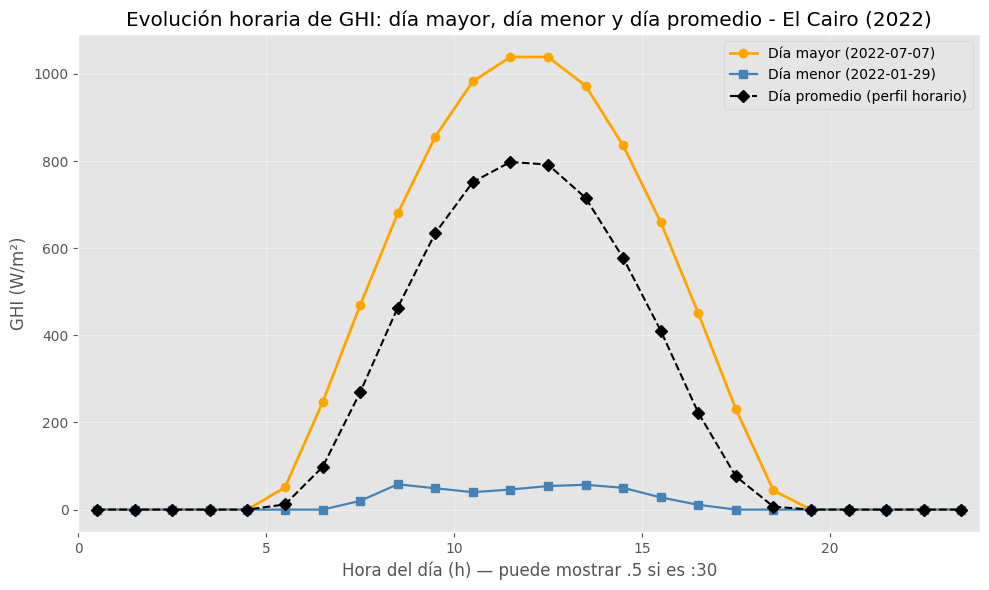

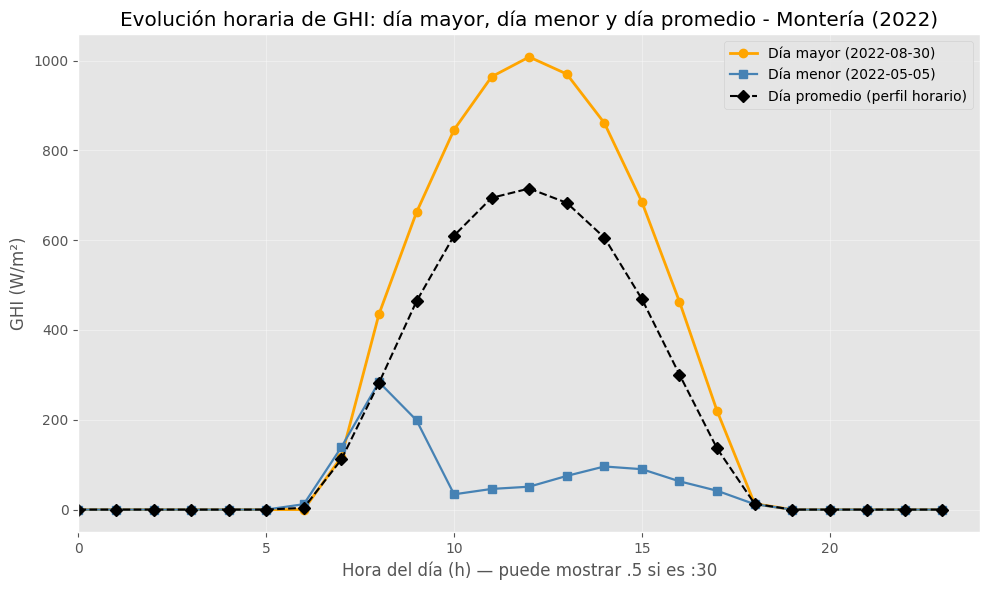

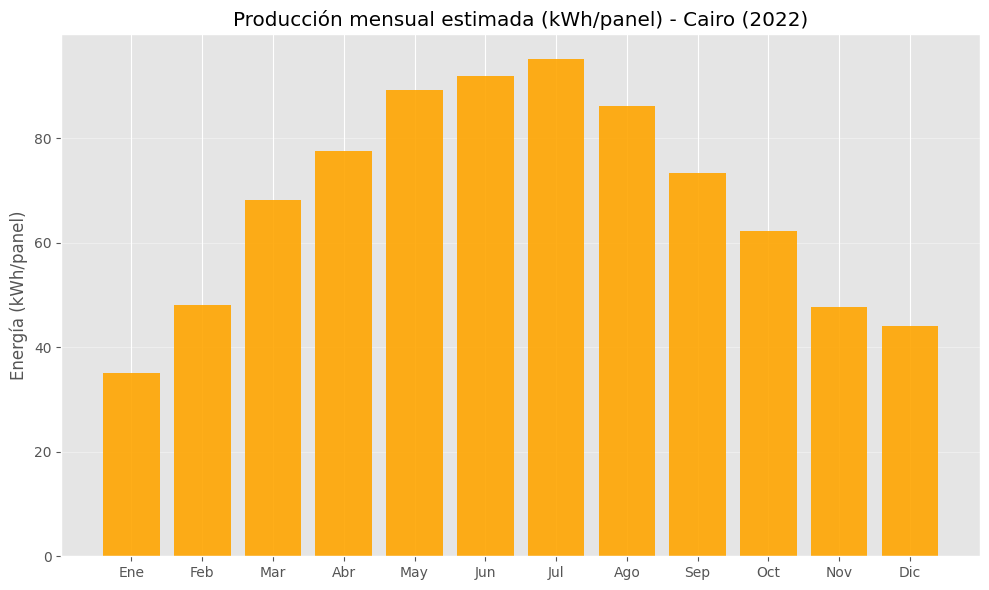

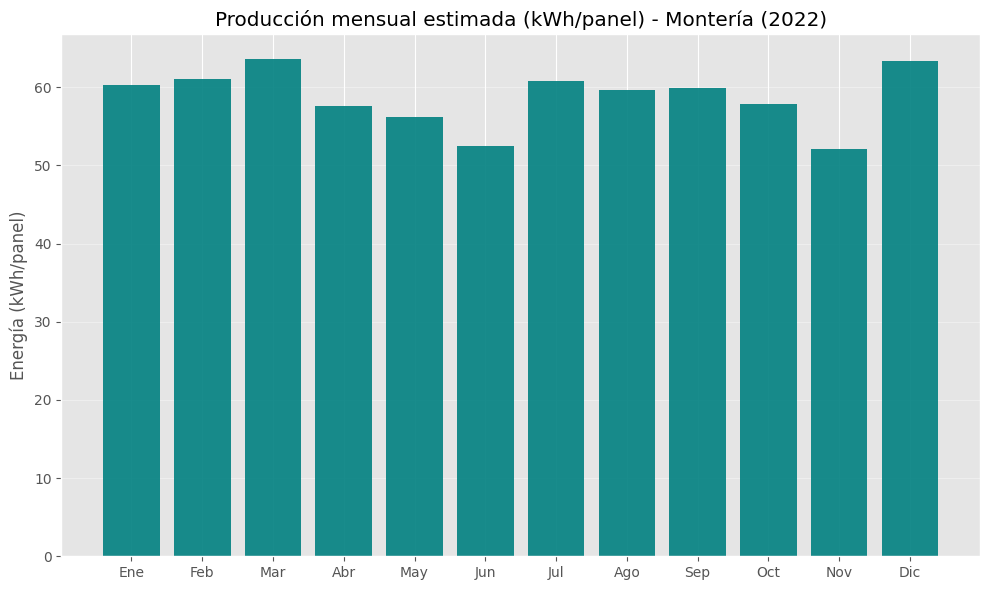

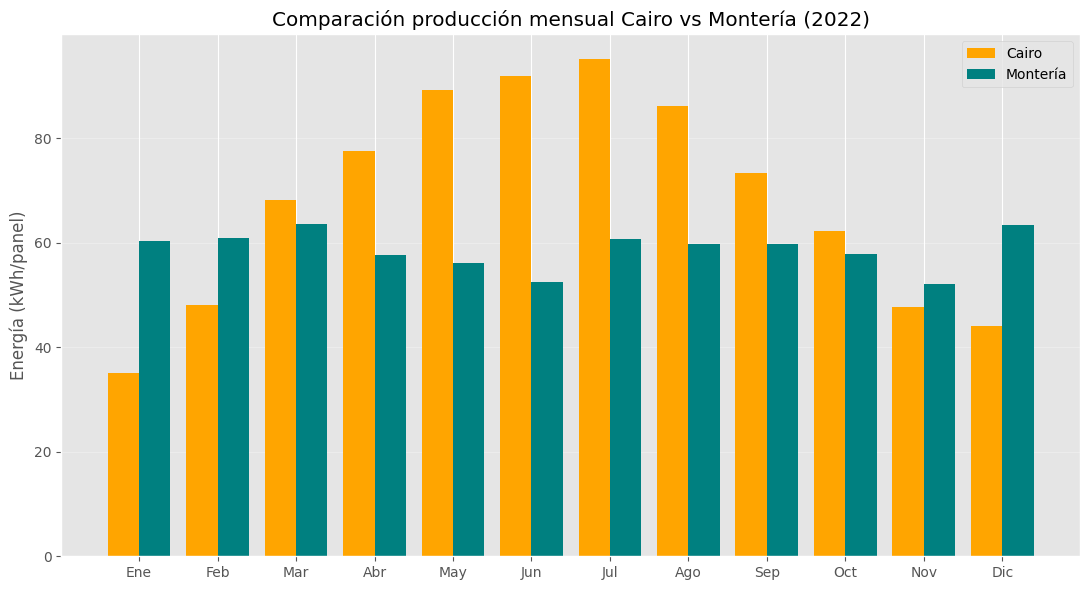


=== TABLA COMPARATIVA FINAL ===
                        Indicador                             Cairo                          Montería
        GHI promedio anual (W/m²)                            242.87                            212.03
Energía anual disponible (kWh/m²)                           2127.54                           1857.38
        Energía anual (kWh/panel)                            818.71                            704.67
    Energía diaria media (kWh/m²)                              5.83                              5.09
                  Hora máxima GHI 2022-07-06 11:30:00 (1042.0 W/m²) 2022-04-22 12:00:00 (1014.0 W/m²)


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

plt.style.use("ggplot")

# -------------------------
# Parámetros del panel
# -------------------------
PANEL_AREA = 1.95        # m²
PANEL_EFF = 0.20         # eficiencia (decimal)
GAMMA = -0.004           # coef. temperatura (1/°C) => -0.4%/°C
KV = 0.002               # coef. viento (por m/s)
TREF = 25.0              # °C referencia STC
DELTA_H = 1.0            # horas (los datos fueron descargados en resolución horaria)

# -------------------------
# 1. Cargar datos
# -------------------------
cairo = pd.read_csv("Cairo_data.csv", skiprows=2)
monteria = pd.read_csv("Monteria_data.csv", skiprows=2)

for df in (cairo, monteria):
    df['datetime'] = pd.to_datetime(df[['Year','Month','Day','Hour','Minute']])

# columnas que vamos a usar (si faltan, se ignoran y se usan defaults)
cols_needed = ['datetime','Year','Month','Day','Hour','Minute','GHI','Temperature','Wind Speed']
def keep_cols(df):
    cols = [c for c in cols_needed if c in df.columns]
    return df[cols].copy()

cairo = keep_cols(cairo)
monteria = keep_cols(monteria)

# -------------------------
# 2. Función: estadística y energía disponible (Wh/m²)
# -------------------------
def estadisticas_y_energia(df, nombre):
    out = {}
    ghi = df['GHI'].to_numpy(dtype=float)

    # convertir a dataframe local
    df_local = df.copy()
    df_local['date'] = df_local['datetime'].dt.date
    df_local['month'] = df_local['datetime'].dt.month

    # Energía por registro (Wh/m²) = GHI [W/m²] * DELTA_H [h]
    energia_registro = ghi * DELTA_H

    # Energía diaria y mensual (Wh/m²)
    energia_diaria = df_local.groupby('date')['GHI'].apply(lambda s: (s.to_numpy(dtype=float) * DELTA_H).sum())
    energia_mensual = df_local.groupby('month')['GHI'].apply(lambda s: (s.to_numpy(dtype=float) * DELTA_H).sum()).reindex(range(1,13), fill_value=0.0)
    energia_anual_wh_m2 = energia_diaria.sum()

    # Radiación promedio (W/m²)
    ghi_diario_prom = df_local.groupby('date')['GHI'].mean().to_numpy()
    ghi_mensual_prom = df_local.groupby('month')['GHI'].mean().reindex(range(1,13), fill_value=np.nan).to_numpy()
    ghi_anual_prom = np.nanmean(ghi)  # promedio de todos los registros (W/m²)

    # Instante de máxima / mínima GHI (usamos numpy para eficiencia)
    if np.all(np.isnan(ghi)):
        idx_max = idx_min = None
        hora_max = hora_min = None
        max_GHI = min_GHI = np.nan
    else:
        idx_max = int(np.nanargmax(ghi))
        idx_min = int(np.nanargmin(ghi))
        fila_max = df_local.iloc[idx_max]
        fila_min = df_local.iloc[idx_min]
        hora_max = fila_max['datetime']
        hora_min = fila_min['datetime']
        max_GHI = ghi[idx_max]
        min_GHI = ghi[idx_min]

    # Perfil horario promedio: respetar minutos (:00 o :30)
    df_local['hour_decimal'] = df_local['datetime'].dt.hour + df_local['datetime'].dt.minute/60.0
    perfil_promedio = df_local.groupby('hour_decimal')['GHI'].mean()  # puede tener índices 0.0, 0.5, 1.0, 1.5, ...

    # Empaquetar
    out['energia_diaria_wh_m2'] = energia_diaria
    out['energia_mensual_wh_m2'] = energia_mensual
    out['energia_anual_wh_m2'] = energia_anual_wh_m2
    out['ghi_diario_prom_w_m2'] = np.nanmean(ghi_diario_prom)
    out['ghi_mensual_prom_w_m2'] = ghi_mensual_prom
    out['ghi_anual_prom_w_m2'] = ghi_anual_prom
    out['hora_max_datetime'] = hora_max
    out['hora_min_datetime'] = hora_min
    out['hora_max_GHI_w_m2'] = max_GHI
    out['hora_min_GHI_w_m2'] = min_GHI
    out['perfil_promedio_hourly'] = perfil_promedio
    return out

res_cairo = estadisticas_y_energia(cairo, "Cairo")
res_monteria = estadisticas_y_energia(monteria, "Montería")

# -------------------------
# 3. Impresiones claras y tablas (unidades incluidas)
# -------------------------
def imprimir_resumen(res, nombre):
    print("\n" + "="*70)
    print(f"RESUMEN: {nombre}")
    print("="*70)
    print(f"Radiación promedio diario (GHI_mean_over_days): {res['ghi_diario_prom_w_m2']:.2f} W/m²")
    print(f"Radiación promedio mensual (avg of month means): {np.nanmean(res['ghi_mensual_prom_w_m2']):.2f} W/m²")
    print(f"Radiación promedio anual (media de registros): {res['ghi_anual_prom_w_m2']:.2f} W/m²")
    print()
    if res['hora_max_datetime'] is not None:
        print(f"Instante de máxima radiación: {res['hora_max_datetime']} -> {res['hora_max_GHI_w_m2']:.1f} W/m²")
        print(f"Instante de mínima radiación: {res['hora_min_datetime']} -> {res['hora_min_GHI_w_m2']:.1f} W/m²")
    print()
    # Energía disponible (Wh/m²)
    print(f"Energía total anual disponible: {res['energia_anual_wh_m2']:.0f} Wh/m² ({res['energia_anual_wh_m2']/1000:.1f} kWh/m²)")
    print(f"Energía diaria media disponible: {np.mean(res['energia_diaria_wh_m2']):.0f} Wh/m²")
    print(f"Energía diaria máxima: {res['energia_diaria_wh_m2'].max():.0f} Wh/m²")
    print(f"Energía diaria mínima: {res['energia_diaria_wh_m2'].min():.0f} Wh/m²")
    print()
    # Variaciones estacionales: tabla
    months = ['Ene','Feb','Mar','Abr','May','Jun','Jul','Ago','Sep','Oct','Nov','Dic']
    ghi_month = res['ghi_mensual_prom_w_m2']
    energia_month_kwhm2 = (res['energia_mensual_wh_m2'] / 1000.0)
    tabla = pd.DataFrame({
        'Mes': months,
        'GHI_promedio (W/m²)': np.round(ghi_month, 2),
        'Energia_mes (kWh/m²)': np.round(energia_month_kwhm2.values, 2)
    })
    print("Variación estacional (promedio GHI y energía mensual):")
    print(tabla.to_string(index=False))
    print("="*70)

imprimir_resumen(res_cairo, "El Cairo (2022)")
imprimir_resumen(res_monteria, "Montería (2022)")

# -------------------------
# 4. Modelo del panel (vectorizado) y potencial energético
# -------------------------
class PanelSolar:
    def __init__(self, area=PANEL_AREA, eficiencia=PANEL_EFF, gamma=GAMMA, kv=KV, tref=TREF):
        self.area = area
        self.eficiencia = eficiencia
        self.gamma = gamma
        self.kv = kv
        self.tref = tref

    def potencia_inst_W(self, G, T, v):
        # vectorizado: G (W/m²), T (°C), v (m/s)
        G = np.array(G, dtype=float)
        T = np.array(T, dtype=float)
        v = np.array(v, dtype=float)
        factor_temp = 1.0 + self.gamma * (T - self.tref)
        factor_viento = 1.0 + self.kv * (v - 1.0)
        factor_viento = np.maximum(factor_viento, 1.0 - 0.10)  # no más del 10% de mejora
        P_inst = G * self.area * self.eficiencia * factor_temp * factor_viento  # W
        return P_inst

    def energia_wh_total(self, df):
        G = df['GHI'].to_numpy(dtype=float)
        T = df['Temperature'].to_numpy(dtype=float) if 'Temperature' in df.columns else np.full_like(G, self.tref)
        v = df['Wind Speed'].to_numpy(dtype=float) if 'Wind Speed' in df.columns else np.ones_like(G)
        P_inst = self.potencia_inst_W(G, T, v)
        energia_wh = P_inst * DELTA_H
        return energia_wh.sum(), energia_wh

    def energia_por_periodo(self, df):
        # devuelve energía diaria (Wh/panel serie), mensual (Wh/panel serie), total Wh
        total_wh, energia_per_reg = self.energia_wh_total(df)
        df_local = df.copy()
        df_local['energia_reg_wh'] = energia_per_reg
        df_local['date'] = df_local['datetime'].dt.date
        df_local['month'] = df_local['datetime'].dt.month
        energia_diaria_panel = df_local.groupby('date')['energia_reg_wh'].sum()
        energia_mensual_panel = df_local.groupby('month')['energia_reg_wh'].sum().reindex(range(1,13), fill_value=0.0)
        return energia_diaria_panel, energia_mensual_panel, total_wh

panel = PanelSolar()

panel_cairo_diaria, panel_cairo_mensual, panel_cairo_anual_wh = panel.energia_por_periodo(cairo)
panel_monteria_diaria, panel_monteria_mensual, panel_monteria_anual_wh = panel.energia_por_periodo(monteria)

# Imprimir potencial energético
print("\n" + "="*70)
print("POTENCIAL ENERGÉTICO (Panel referencia) - RESULTADOS")
print("="*70)
tabla_panel = pd.DataFrame({
    'Ubicación': ['Cairo', 'Montería'],
    'Energía anual (kWh/panel)': [round(panel_cairo_anual_wh/1000,2), round(panel_monteria_anual_wh/1000,2)],
    'Energía anual (Wh/panel)': [int(panel_cairo_anual_wh), int(panel_monteria_anual_wh)],
    'Energía diaria promedio (kWh/panel)': [round(panel_cairo_diaria.mean()/1000, 2), round(panel_monteria_diaria.mean()/1000, 2)]
})
print(tabla_panel.to_string(index=False))
print("="*70)

# -------------------------
# 5. Gráficas
#    - Evolución día mayor, día menor, día promedio (respeta hh:mm)
#    - Producción mensual estimada (kWh/panel)
#    - Comparación mensual Cairo vs Montería (kWh/panel)
# -------------------------
def plot_evolucion_dia(df, res, nombre):
    energia_diaria = res['energia_diaria_wh_m2']
    day_max = energia_diaria.idxmax()
    day_min = energia_diaria[energia_diaria > 0].idxmin() if (energia_diaria>0).any() else energia_diaria.idxmin()

    df_local = df.copy()
    df_local['date'] = df_local['datetime'].dt.date
    # hour_decimal respeta :00 o :30
    df_local['hour_decimal'] = df_local['datetime'].dt.hour + df_local['datetime'].dt.minute/60.0

    # series representativas indexadas por hour_decimal
    s_max = df_local[df_local['date'] == day_max].set_index('hour_decimal')['GHI']
    s_min = df_local[df_local['date'] == day_min].set_index('hour_decimal')['GHI']
    perfil = res['perfil_promedio_hourly']

    plt.figure(figsize=(10,6))
    plt.plot(s_max.index, s_max.values, marker='o', label=f"Día mayor ({day_max})", color='orange', lw=2)
    plt.plot(s_min.index, s_min.values, marker='s', label=f"Día menor ({day_min})", color='steelblue', lw=1.6)
    plt.plot(perfil.index, perfil.values, marker='D', linestyle='--', label="Día promedio (perfil horario)", color='black')
    plt.title(f"Evolución horaria de GHI: día mayor, día menor y día promedio - {nombre} (2022)")
    plt.xlabel("Hora del día (h) — puede mostrar .5 si es :30")
    plt.ylabel("GHI (W/m²)")
    plt.xlim(0, 24)
    plt.grid(alpha=0.35)
    plt.legend()
    plt.tight_layout()
    plt.show()

# Graficar para ambas ubicaciones
plot_evolucion_dia(cairo, res_cairo, "El Cairo")
plot_evolucion_dia(monteria, res_monteria, "Montería")

def plot_produccion_mensual(panel_mensual_wh, nombre, color):
    meses = np.arange(1,13)
    vals_kwh = panel_mensual_wh.reindex(range(1,13), fill_value=0.0).to_numpy() / 1000.0
    labels = ['Ene','Feb','Mar','Abr','May','Jun','Jul','Ago','Sep','Oct','Nov','Dic']
    plt.figure(figsize=(10,6))
    plt.bar(meses, vals_kwh, color=color, alpha=0.9)
    plt.xticks(meses, labels)
    plt.ylabel("Energía (kWh/panel)")
    plt.title(f"Producción mensual estimada (kWh/panel) - {nombre} (2022)")
    plt.grid(axis='y', alpha=0.35)
    plt.tight_layout()
    plt.show()

plot_produccion_mensual(panel_cairo_mensual, "Cairo", "orange")
plot_produccion_mensual(panel_monteria_mensual, "Montería", "teal")

# Comparación mensual (Cairo vs Montería) - gráfico combinado
months = np.arange(1,13)
cairo_kwh = panel_cairo_mensual.reindex(range(1,13), fill_value=0.0).to_numpy()/1000.0
monteria_kwh = panel_monteria_mensual.reindex(range(1,13), fill_value=0.0).to_numpy()/1000.0
labels = ['Ene','Feb','Mar','Abr','May','Jun','Jul','Ago','Sep','Oct','Nov','Dic']

x = np.arange(len(months))
width = 0.4
plt.figure(figsize=(11,6))
plt.bar(x - width/2, cairo_kwh, width, label='Cairo', color='orange')
plt.bar(x + width/2, monteria_kwh, width, label='Montería', color='teal')
plt.xticks(x, labels)
plt.ylabel("Energía (kWh/panel)")
plt.title("Comparación producción mensual Cairo vs Montería (2022)")
plt.legend()
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

# -------------------------
# 6. Tabla comparativa final (resumen clave con unidades)
# -------------------------
tabla_final = pd.DataFrame({
    'Indicador': [
        'GHI promedio anual (W/m²)',
        'Energía anual disponible (kWh/m²)',
        'Energía anual (kWh/panel)',
        'Energía diaria media (kWh/m²)',
        'Hora máxima GHI'
    ],
    'Cairo': [
        f"{res_cairo['ghi_anual_prom_w_m2']:.2f}",
        f"{res_cairo['energia_anual_wh_m2']/1000:.2f}",
        f"{panel_cairo_anual_wh/1000:.2f}",
        f"{np.mean(res_cairo['energia_diaria_wh_m2'])/1000:.2f}",
        f"{res_cairo['hora_max_datetime']} ({res_cairo['hora_max_GHI_w_m2']:.1f} W/m²)"
    ],
    'Montería': [
        f"{res_monteria['ghi_anual_prom_w_m2']:.2f}",
        f"{res_monteria['energia_anual_wh_m2']/1000:.2f}",
        f"{panel_monteria_anual_wh/1000:.2f}",
        f"{np.mean(res_monteria['energia_diaria_wh_m2'])/1000:.2f}",
        f"{res_monteria['hora_max_datetime']} ({res_monteria['hora_max_GHI_w_m2']:.1f} W/m²)"
    ]
})
print("\n=== TABLA COMPARATIVA FINAL ===")
print(tabla_final.to_string(index=False))
